In [60]:
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.linear_model import ElasticNet, SGDRegressor, Ridge
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt

In [38]:
response_path = "data/D16Feb2024_eccco_response_feldman_m_el_with_tables_s_i_lw_coopersun.fits"
response = fits.getdata(response_path)
response_hdul = fits.open(response_path)

weights_path = "data/eccco_is_lw_forwardmodel_sample_weights_psf4pix_el.fits"
weights = fits.getdata(weights_path)

image_path = "data/eccco_is_lw_forwardmodel_thermal_response_psf4pix_el.fits"
image = fits.getdata(image_path)

In [39]:
response.shape, weights.shape, image.shape

((21, 1395, 5491), (2048, 5491), (2048, 5491))

In [40]:
dep_name = response_hdul[0].header['DEPNAME']
dep_list = response_hdul[1].data[dep_name]
dep_list = np.round(dep_list, decimals=2)
dep_index_list = response_hdul[1].data['index']
print("dep_list", dep_list)

dep_list [5.5 5.6 5.7 5.8 5.9 6.  6.1 6.2 6.3 6.4 6.5 6.6 6.7 6.8 6.9 7.  7.1 7.2
 7.3 7.4 7.5]


In [41]:
num_dep, num_field_angles, rsp_func_width = np.shape(response)

num_deps = len(dep_list)

begin_slit_index, end_slit_index = 0, 1394
solution_fov_width = 1

num_field_angles = (end_slit_index - begin_slit_index) + 1
calc_num_slits = divmod(num_field_angles, solution_fov_width)
num_slits =  int(calc_num_slits[0])
center_slit = divmod(end_slit_index - begin_slit_index, 2)[0] + begin_slit_index
half_slits = divmod(num_slits, 2)
        
prepared_response = np.zeros((num_deps  * num_slits, rsp_func_width), dtype=np.float32)
response_count = 0
for index in dep_index_list:
    # Smooth over dependence.
    slit_count = 0
    for slit_num in range(center_slit - (half_slits[0] * solution_fov_width), center_slit + ((half_slits[0] *solution_fov_width) + 1), solution_fov_width):
    #for slit_num in range(begin_slit_index, (end_slit_index + 1), self.solution_fov_width):
        if solution_fov_width == 1:
            prepared_response[(num_deps  * slit_count) + response_count, :] = response[index, slit_num, :]
        else:
            raise NotImplementedError("dummy marcus")
        slit_count += 1
    response_count += 1

In [42]:
prepared_response = prepared_response.transpose()

In [43]:
f = ExtraTreesRegressor()

In [44]:
X = prepared_response
y = image

In [45]:
X.shape, y.shape

((5491, 29295), (2048, 5491))

In [20]:
X[1].reshape(1, -1).shape

(1, 29295)

In [22]:
%%timeit

f.fit(X[1].reshape(1, -1), y.transpose()[1].reshape(1, -1))

40.4 ms ± 127 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [53]:
y.transpose()[1].reshape(1, -1).shape

(1, 2048)

In [77]:
alpha = 5
rho = 0.1
r = Ridge(alpha=alpha, fit_intercept=False, solver='auto')

In [78]:
%%timeit

r.fit(X[425].reshape(1, -1), y.transpose()[425].reshape(1, -1))

85.8 ms ± 2.97 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [79]:
out = r.predict(X[425].reshape(1, -1))

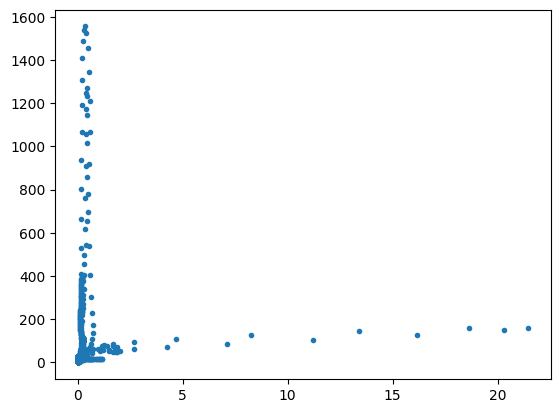

In [81]:
fig, ax = plt.subplots()
ax.plot(y.transpose()[1], out[0], '.')

In [82]:
enet = ElasticNet(fit_intercept=False, alpha=alpha, l1_ratio=rho)

In [83]:
enet.fit(X[425].reshape(1, -1), y.transpose()[425].reshape(1, -1))

/Users/jhughes/Desktop/repos/overlappogram/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.758e-02, tolerance: 5.692e-02
  model = cd_fast.enet_coordinate_descent(
/Users/jhughes/Desktop/repos/overlappogram/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.033e-02, tolerance: 5.834e-02
  model = cd_fast.enet_coordinate_descent(
/Users/jhughes/Desktop/repos/overlappogram/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, chec

KeyboardInterrupt: 

In [100]:
a = "output/eccco_is_lw_forwardmodel_thermal_response_psf4pix_el_model_predicted_data_x2_1.0_5_wpsf.fits"

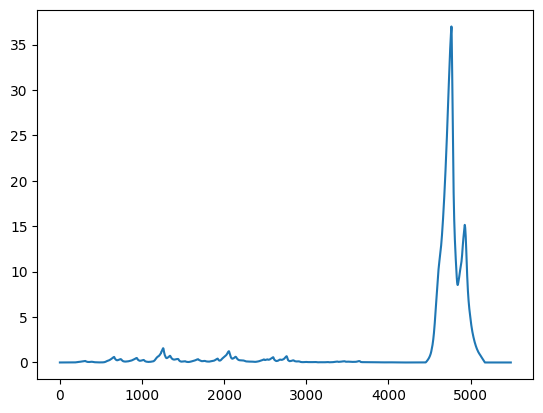

In [101]:
fig, ax = plt.subplots()
ax.plot(fits.open(a)[0].data[451])


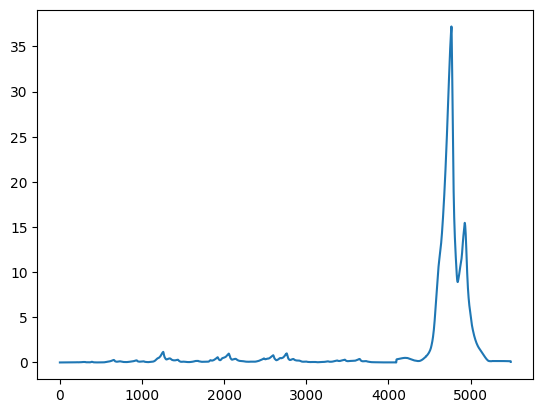

In [102]:
fig, ax = plt.subplots()
ax.plot(fits.open(a)[0].data[451])
